<a href="https://colab.research.google.com/github/Ashrafhusen/LearningMLmodels/blob/master/LSTM_STOCK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf

In [8]:
df = yf.download("AAPL", start="2022-01-01", end="2024-01-01")

/tmp/ipython-input-3266791598.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2022-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


In [9]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2022-01-03,178.645660,179.499589,174.425155,174.542932,104487900
2022-01-04,176.378357,179.558473,175.809076,179.254206,99310400
2022-01-05,171.686707,176.839663,171.411883,176.290017,94537600
2022-01-06,168.820694,172.059699,168.467348,169.507752,96904000
2022-01-07,168.987534,170.921120,167.868606,169.694226,86709100
...,...,...,...,...,...
2023-12-22,192.192566,193.989405,191.567141,193.761066,37149600
2023-12-26,191.646561,192.480450,191.428159,192.202487,28919300


In [10]:
df = df[['Close']]

In [11]:
df['Return'] = df['Close'].pct_change()

/tmp/ipython-input-2873848681.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'] = df['Close'].pct_change()


In [12]:
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

/tmp/ipython-input-3190076570.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)


In [13]:
df.dropna(inplace=True)


/tmp/ipython-input-658506679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [14]:
df

Price,Close,Return,Target
Ticker,AAPL,,
Date,,,
2022-01-04,176.378357,-0.012692,0
2022-01-05,171.686707,-0.026600,0
2022-01-06,168.820694,-0.016693,1
2022-01-07,168.987534,0.000988,1
2022-01-10,169.007172,0.000116,1
...,...,...,...
2023-12-22,192.192566,-0.005547,0
2023-12-26,191.646561,-0.002841,1


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader

In [16]:
import numpy as np

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class StockDataset(Dataset):
    def __init__(self, data, seq_len=30):
        self.X = []
        self.y = []
        for i in range(len(data) - seq_len):
            self.X.append(data[i:i+seq_len, 0])  # return
            self.y.append(data[i+seq_len, 1])    # target
        self.X = torch.tensor(self.X, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(self.y, dtype=torch.long)

    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

df[['Return']] = (df[['Return']] - df['Return'].mean()) / df['Return'].std()
dataset = StockDataset(df[['Return', 'Target']].values, seq_len=30)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


/tmp/ipython-input-331037980.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Return']] = (df[['Return']] - df['Return'].mean()) / df['Return'].std()
/tmp/ipython-input-331037980.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  self.X = torch.tensor(self.X, dtype=torch.float32).unsqueeze(-1)


In [19]:
import torch.nn as nn

class StockLSTM(nn.Module):
    def __init__(self, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

In [20]:
model = StockLSTM()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.7100
Epoch 2, Loss: 0.6851
Epoch 3, Loss: 0.7088
Epoch 4, Loss: 0.6825
Epoch 5, Loss: 0.7024
Epoch 6, Loss: 0.6984
Epoch 7, Loss: 0.6693
Epoch 8, Loss: 0.6821
Epoch 9, Loss: 0.6814
Epoch 10, Loss: 0.6753


In [22]:
model.eval()
with torch.no_grad():
    test_input = torch.tensor(df[['Return']].values[-30:], dtype=torch.float32).unsqueeze(0)
    output = model(test_input)
    pred = torch.argmax(output, dim=1).item()
    print("Prediction for next day:", "Up" if pred == 1 else "Down")

Prediction for next day: Up


In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_predictions(model, dataset, df, seq_len=30, num_days=100):
    model.eval()
    preds = []
    actuals = []

    with torch.no_grad():
        for i in range(len(dataset) - num_days, len(dataset)):
            x, y = dataset[i]
            output = model(x.unsqueeze(0))  # input shape: (1, seq_len, 1)
            pred = torch.argmax(output, dim=1).item()
            preds.append(pred)
            actuals.append(y.item())

    dates = df.index[-num_days:]
    prices = df['Close'].iloc[-num_days:]

    plt.figure(figsize=(14, 5))

    # Plot Close Price line
    plt.plot(dates, prices, color='blue', alpha=0.4, label='Close Price')

    # Plot predictions
    for i in range(num_days):
        correct = preds[i] == actuals[i]
        color = 'green' if actuals[i] == 1 else 'red'
        marker = 'o' if correct else 'x'
        plt.scatter(dates[i], prices.iloc[i], c=color, marker=marker, s=70, alpha=0.8)

    # Custom legend
    correct_patch = mpatches.Patch(color='green', label='Actual: Up')
    wrong_patch = mpatches.Patch(color='red', label='Actual: Down')
    marker1 = plt.Line2D([], [], color='black', marker='o', linestyle='None', label='Correct')
    marker2 = plt.Line2D([], [], color='black', marker='x', linestyle='None', label='Wrong')

    plt.legend(handles=[correct_patch, wrong_patch, marker1, marker2], loc='upper left', fontsize=8)

    plt.title("📈 LSTM Stock Prediction — Green: Up, Red: Down, X: Wrong Prediction")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-3052026821.py:44: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



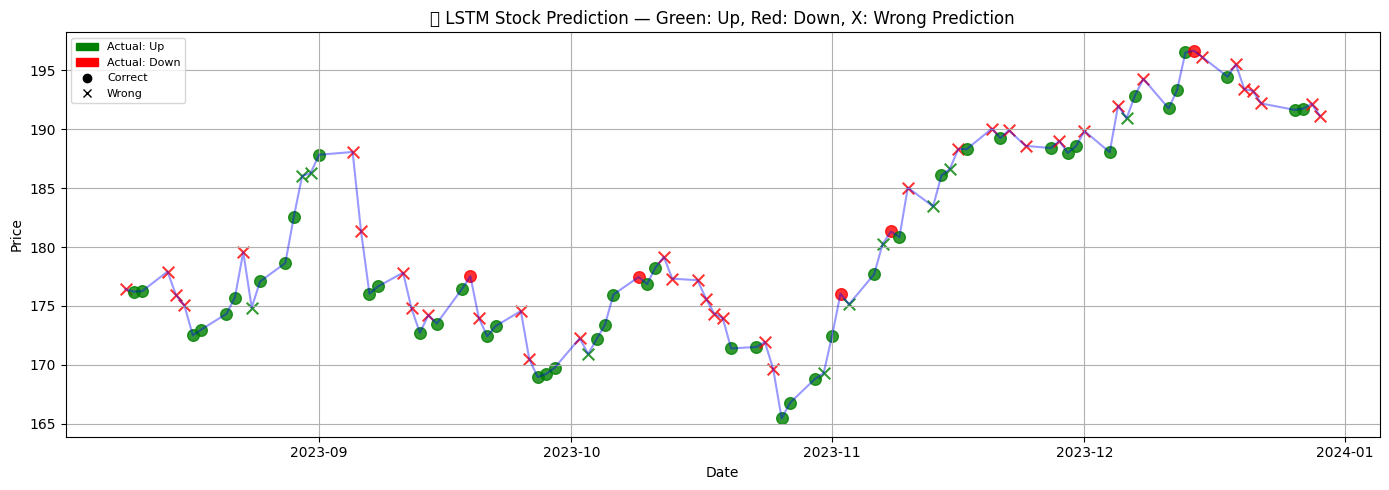

In [28]:
plot_predictions(model, dataset, df)